In [86]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [157]:
df = pd.read_csv('loan_sanction_train.csv', delimiter=',')
df['Loan_Status'].value_counts()

Loan_Status
Y    422
N    192
Name: count, dtype: int64

In [135]:
df.sample(5)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
387,LP002243,Male,Yes,0,Not Graduate,No,3010,3136.0,NaN,360.0,0.0,Urban,N
123,LP001432,Male,Yes,2,Graduate,No,2957,0.0,81.0,360.0,1.0,Semiurban,Y
324,LP002065,Male,Yes,3+,Graduate,No,15000,0.0,300.0,360.0,1.0,Rural,Y
68,LP001238,Male,Yes,3+,Not Graduate,Yes,7100,0.0,125.0,60.0,1.0,Urban,Y
274,LP001896,Male,Yes,2,Graduate,No,3900,0.0,90.0,360.0,1.0,Semiurban,Y


<Axes: ylabel='Density'>

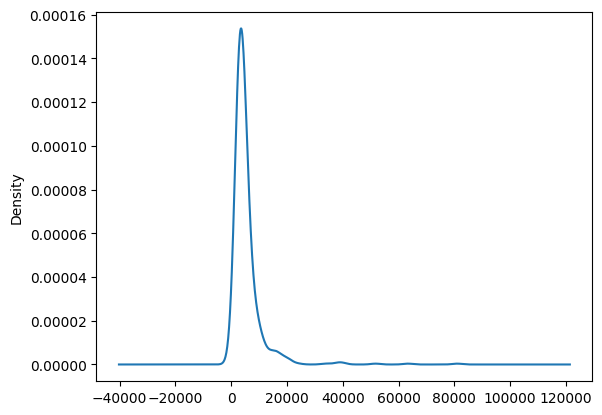

In [158]:
df["ApplicantIncome"].plot(kind='density')

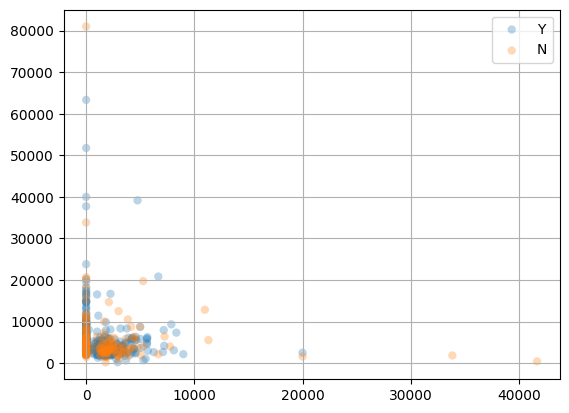

In [159]:
fig, ax = plt.subplots()
for color in [('tab:blue','Y'), ('tab:orange','N')]:
    
    df_t = df[df['Loan_Status'] == color[1]]
    ax.scatter(df_t['CoapplicantIncome'], df_t['ApplicantIncome'], c=color[0], label=color[1],
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()    

In [91]:
df["ApplicantIncome"].max()

81000

In [160]:
df.sample(1)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
473,LP002522,Female,No,0,Graduate,Yes,2500,0.0,93.0,360.0,NaN,Urban,Y


In [161]:
maxSal = 20000
# df['ApplicantIncome'] = df['ApplicantIncome'].where(df['ApplicantIncome'] <= maxSal, maxSal)
# df['CoapplicantIncome'] = df['CoapplicantIncome'].where(df['CoapplicantIncome'] <= maxSal, maxSal)
df['ApplicantIncome'] = df['ApplicantIncome'] * 1000
df['CoapplicantIncome'] = df['CoapplicantIncome'] * 1000
df['LoanAmount'] = df['LoanAmount'] * 1000

df['Total_income'] = df['ApplicantIncome']+df['CoapplicantIncome']
df['ApplicantIncomeLog']  = np.log(df['ApplicantIncome'] )
df['CoapplicantIncomeLog']  = np.log(df['CoapplicantIncome'] )
df['Total_income_log']  = np.log(df['Total_income'] )

df.drop(['Total_income', 'ApplicantIncome','CoapplicantIncome'],axis=1, inplace=True)

df.replace([np.inf, -np.inf], 0, inplace=True)

c:\Apps\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [162]:
df["Credit_History"].fillna(1, inplace=True)
df["Loan_Amount_Term"].fillna(360, inplace=True)
df["Self_Employed"].fillna("Yes", inplace=True)
df["Education"].fillna("Not Graduate", inplace=True)
df["Dependents"].fillna('0', inplace=True)
df["Gender"].fillna("Unknown", inplace=True)
df = df[df['LoanAmount'].notna()]
df["Married"].fillna("No", inplace=True)


# Gav sämre resultat
#df['ApplicantIncome'] = np.clip(df['ApplicantIncome'], a_max=10000, a_min=None)
#df['CoapplicantIncome']= np.clip(df['CoapplicantIncome'], a_max=10000, a_min=None)

In [163]:
df.sample(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,ApplicantIncomeLog,CoapplicantIncomeLog,Total_income_log
21,LP001046,Male,Yes,1,Graduate,No,315000.0,360.0,1.0,Urban,Y,15.599742,15.542732,16.264790
558,LP002798,Male,Yes,0,Graduate,No,162000.0,360.0,1.0,Semiurban,Y,15.173148,14.797214,15.695891


In [164]:
for c in df.columns:

    print(c, " ", df[c].isnull().values.any())

Loan_ID   False
Gender   False
Married   False
Dependents   False
Education   False
Self_Employed   False
LoanAmount   False
Loan_Amount_Term   False
Credit_History   False
Property_Area   False
Loan_Status   False
ApplicantIncomeLog   False
CoapplicantIncomeLog   False
Total_income_log   False


In [165]:

df = df.drop(columns=['Loan_ID'], axis=1)
df_loan_status = df['Loan_Status']
df = df.drop(columns=['Loan_Status'], axis=1)

In [166]:
df["Dependents"].unique()

array(['1', '0', '2', '3+'], dtype=object)

In [167]:
print ("asdasd1")
df_loan_status = pd.Series( df_loan_status, name='Loan_Status').to_frame()
print ("asdasd2")
for c in df.select_dtypes(include=object).columns:
    print(c)
    le = LabelEncoder()
    df[c] = le.fit_transform(df[c])

le = LabelEncoder()
df_loan_status['Loan_Status'] = le.fit_transform(df_loan_status['Loan_Status'])    

asdasd1
asdasd2
Gender
Married
Dependents
Education
Self_Employed
Property_Area


In [168]:
from imblearn.over_sampling import SMOTE
from collections import Counter

undersampler = SMOTE()
X, y = undersampler.fit_resample(X=df, y=df_loan_status)
counter = Counter(y)
print(counter)

Counter({'Loan_Status': 1})


In [169]:
# Split the data
#X_train, X_test, y_train, y_test = train_test_split(df, df_loan_status, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [171]:
import xgboost as xgb
params = {'max_depth': 2, 'eta': 1, 'objective': 'binary:logistic'}
params['nthread'] = 4
params['objective'] = 'binary:logistic'

# Train a model using the scikit-learn API
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', nthread=4, max_depth=2, eta=1)
xgb_classifier.fit(X_train, y_train)

# Convert the model to a native API model


y_pred = xgb_classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

accuracy = xgb_classifier.score(X_test, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

print(classification_report(y_test['Loan_Status'].to_numpy(), y_pred))


Accuracy: 83.50%
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       104
           1       0.81      0.86      0.84       102

    accuracy                           0.83       206
   macro avg       0.84      0.84      0.83       206
weighted avg       0.84      0.83      0.83       206



In [172]:
xgb_classifier.save_model('model.json')

In [185]:
X_test

,Gender,Married,Dependents,Education,Self_Employed,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,ApplicantIncomeLog,CoapplicantIncomeLog,Total_income_log
528,1,0,0,0,0,145000.000000,360.0,1.000000,0,14.742148,14.393808,15.276216
331,1,1,0,0,0,160000.000000,360.0,1.000000,1,14.731401,14.714859,15.416311
735,1,1,0,0,0,158776.167062,360.0,0.776167,0,14.766853,14.495509,15.333723
17,1,1,0,1,0,133000.000000,360.0,1.000000,0,15.402089,0.000000,15.402089
388,0,0,0,1,0,53000.000000,360.0,1.000000,1,14.489984,0.000000,14.489984
...,...,...,...,...,...,...,...,...,...,...,...,...
13,1,1,2,0,0,17000.000000,120.0,1.000000,2,14.077105,13.898012,14.684710
710,0,0,0,0,0,98284.884925,360.0,0.000000,1,15.052424,0.000000,15.052424
277,0,0,0,0,0,115000.000000,360.0,1.000000,1,15.232334,0.000000,15.232334
558,1,0,0,0,1,161000.000000,360.0,1.000000,2,14.973020,14.886066,15.623635


In [19]:
import lightgbm as lgb


train_data = lgb.Dataset(df, label=df_loan_status)

param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'

num_round = 100
bst = lgb.cv(param, train_data, num_round, nfold=5)

[LightGBM] [Info] Number of positive: 329, number of negative: 144
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 473, number of used features: 11
[LightGBM] [Info] Number of positive: 328, number of negative: 145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 473, number of used features: 11
[LightGBM] [Info] Number of positive: 329, number of negative: 145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data